# with comms return and action counters

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import pickle
import os
import itertools
plt.style.use('seaborn-poster')

In [2]:
webplot_dir = './webplot_results'
results_dir = './results'
eval_dir = './logs'
incremental_dir = './incremental'
variants = {#'Rainbow': ('belief-1', False),
            'stack': ('stack4_l', False),
            'nostack': ('nostack_l', False),
            'Belief lvl 0': ('belief0', False),
            'Belief lvl 1, b=0.0': ('beta0', False),
            'Belief lvl 1, b=2.0': ('beta2', True),
            'Belief lvl 1, b=5.0': ('beta5', True),
            'Belief lvl 1, b=7.0': ('beta7', True),
            'Belief lvl 1, b=10.0': ('beta10', True),
            'Belief lvl 1, b=25.0': ('beta25', True),
            }
total_steps = 1e8

def decimate(arr, n):
    end =  n * int(len(arr)/n)
    return np.median(arr[:end].reshape(-1, n), 1)

In [3]:
webplot_data = {}
for i in range(2,6):
    dat = np.genfromtxt(os.path.join(webplot_dir, '{}player_data.csv').format(i), delimiter=',')
    webplot_data['{} players'.format(i)] = dat

# Theory of Mind Results

In [5]:
experiment = {}

for label, (path, has_comms) in variants.items():
    log_dir = os.path.join(results_dir, path)
    dat = pickle.load(open(os.path.join(log_dir, sorted(os.listdir(log_dir))[-1]), 'rb'))
    dat = sorted(dat.items(), key=lambda v: int(v[0].split("iter")[-1]))
    
    # cumulative timesteps per iteration
    ts = np.cumsum([np.sum(d[1]['train_episode_lengths']) for d in dat])
    
    # average episode length
    ep_lens_avg = np.array([np.mean(d[1]['train_episode_lengths']) for d in dat])
    
    # average extrinsic reward
    avg_return = np.array([d[1]['average_return'] for d in dat])
    
    # episode returns
    ep_rets = []
    for d in dat:
        ep_rets.extend(d[1]['train_episode_returns'])
    
    experiment[label] = {'avg_return': avg_return,
                             'cumulative_steps': ts, 
                             'ep_lens': ep_lens_avg,
                             'ep_rets': ep_rets}
    
    if has_comms:
        # average intrinsic reward
        avg_comms_return = np.array([np.mean(d[1]['train_epsisode_comms_returns']) for d in dat])
        experiment[label]['avg_comms_return'] = avg_comms_return
        
        # move counts
        move_counts = [d[1]['train_move_counts'] for d in dat]
        experiment[label]['move_counts'] = move_counts
    
    # eval episodes if exist
    eval_path = os.path.join(results_dir, "{}.eval".format(path))
    if os.path.exists(eval_path):
        dat = pickle.load(open(os.path.join(eval_path, sorted(os.listdir(eval_path))[-1]), 'rb'))
        dat = sorted(dat.items(), key=lambda v: int(v[0].split("iter")[-1]))
        
        # evaluation episode
        eval_ret = np.array([d[1]['eval_episode_returns'] for d in dat])
        experiment[label]['eval_ret'] = eval_ret
        
        # move counts
        #move_counts = [d[1]['train_move_counts'] for d in dat]
        #experiment[label]['eval_move_counts'] = move_counts
        
    
percent_complete = {v: experiment[v]['cumulative_steps'] / total_steps for v in variants}
run_lens = {k: len(v) for k,v in percent_complete.items()}
iterations = percent_complete[max(run_lens, key=run_lens.get)]

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

# Results

In [ ]:
downsample = 128
labels = {'Belief lvl 0': 'Belief lvl 0', 
          'Belief lvl 1, b=0.0': 'Belief lvl 1', 
          'Belief lvl 1, b=2.0': 'ToM+Comm (ours)',  
          'nostack': 'Rainbow'}

selected_variants = {k:v for k,v in variants.items() if k in labels.keys()}
avg_ret = np.array([experiment[v]['avg_return'] for v in variants])
ret_dict = {v: np.squeeze(avg_ret[i]) for i, v in enumerate(variants)}

df = pd.DataFrame.from_dict(ret_dict, orient='index').T

fig = plt.figure(figsize=(13, 7))

cmap = plt.get_cmap('Blues')
n_var = len(selected_variants)

for i, v in enumerate(selected_variants):
    c = cmap(float(i+2) / (n_var + 2))
    x = decimate(percent_complete[v], downsample)
    y = decimate(df[v].dropna().values, downsample)
    p = plt.plot(x*total_steps, y, label=labels[v])#, c=c)

#plt.plot(webplot_data['2 players'][:,0], 
#         webplot_data['2 players'][:,1],
#         label='Bard et al.', linestyle='dashed', c='darkred')
#plt.title('2 Player')
plt.ylabel('Score')
plt.xlabel('Steps')
plt.xlim((0,total_steps))
plt.legend()

In [ ]:
len(experiment['Belief lvl 1, b=2.0']['eval_ret'][1])

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (13,6))

ax[0].yaxis.tick_right()
ax[0].set_ylabel("Proportion of Games")

ax[1].yaxis.tick_right()

# histogram on the attached axes
rainbow = experiment['nostack']['ep_rets'][-1000:]
ax[0].hist(rainbow, density=True, rwidth=1., bins=25)
mean = np.mean(rainbow)
median = np.median(rainbow)
sd = np.std(rainbow)
ax[0].text(0,.12,'Mean score = {}\nMedian score = {}\ns.d = {}\nn = 1000'.format(mean,median,sd))

b2 = experiment['Belief lvl 1, b=2.0']['ep_rets'][-1000:]
ax[1].hist(b2, density=True, rwidth=1., bins=25, color=p[-1].get_color())
mean = np.mean(b2)
median = np.median(b2)
sd = np.std(b2)
ax[1].text(0,.14,'Mean score = {}\nMedian score = {}\ns.d = {}\nn = 1000'.format(mean,median,sd))

ax[1].set_xlabel("Final Scores")
ax[0].set_xlabel("Final Scores")

_=plt.setp(ax[0].get_yticklabels(), visible=False)

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(rainbow, b2)

In [ ]:
downsample = 128
select = ['Belief lvl 0',
          'Belief lvl 1, b=0.0',
          'Belief lvl 1, b=2.0', 
          'Belief lvl 1, b=7.0', 
          #'Belief lvl 1, b=10.0', 
          'Belief lvl 1, b=25.0',
         ]
betas = ['Belief lvl 0',
         r"$\beta$ = 0",
         r"$\beta$ = 2",
         r"$\beta$ = 7",
         #r"$\beta$ = 10",
         r"$\beta$ = 25"
        ]
selected_variants = {k:v for k,v in variants.items() if k in select}
avg_ret = np.array([experiment[v]['avg_return'] for v in variants])
ret_dict = {v: np.squeeze(avg_ret[i]) for i, v in enumerate(variants)}

df = pd.DataFrame.from_dict(ret_dict, orient='index').T

fig, ax = plt.subplots(2,1,figsize = (10,15))

cmap = plt.get_cmap('Blues')
n_var = len(selected_variants)
for i, v in enumerate(selected_variants):
    c = cmap(float(i+2) / (n_var + 2))
    x = decimate(percent_complete[v], downsample)
    y = decimate(df[v].dropna().values, downsample)
    ax[0].plot(x*total_steps, y, label=betas[i], c=c)

#ax[0].set_title('Communication Weight')
ax[0].set_ylabel('Score')
ax[0].set_xlabel('Steps')
ax[0].set_xlim((0,.6*total_steps))
ax[0].legend(loc=4)

bars = []
for i, v in enumerate(selected_variants):
    bars.append(df[v].dropna().values[-1])

bar_c = [cmap(float(i+2) / (n_var + 2)) for i in range(len(selected_variants))]
ax[1].bar(range(len(bars)), bars, color=bar_c)
_=plt.xticks(range(len(bars)), betas, rotation=45)
for tick in ax[1].xaxis.get_major_ticks():
    tick.set_pad(20)

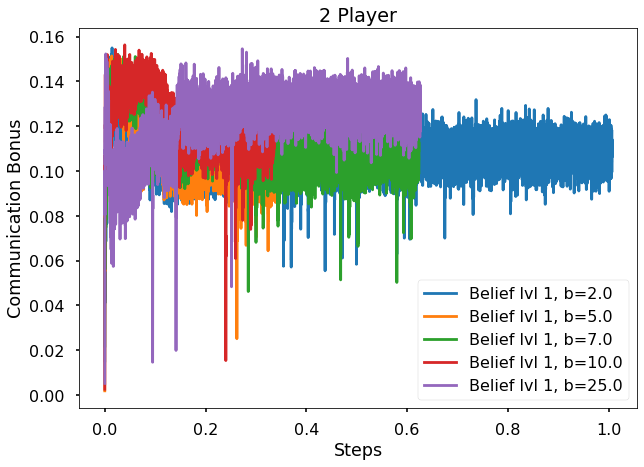

In [278]:
ret_dict = {}
div_by_beta = True

for label, (path, has_comms) in variants.items():
    if has_comms:
        scale = float(label.split('=')[-1]) if div_by_beta else 1
        ret_dict[label] = np.squeeze(experiment[label]['avg_comms_return']) / scale

df = pd.DataFrame.from_dict(ret_dict, orient='index').T
plt.figure(figsize = (10,7))

for v, (path, has_comms) in variants.items():
    if has_comms:
        plt.plot(percent_complete[v], df[v].values[:len(percent_complete[v])], label=v)

plt.title('2 Player')
plt.ylabel('Communication Bonus')
plt.xlabel('Steps')

plt.legend()

In [288]:
downsample = 128
exp_lab = 'Belief lvl 1, b=2.0'
drop = ['DEAL']

dat = experiment[exp_lab]['move_counts']
action_ratios = []
for d in dat:
    dat = pd.DataFrame(d).fillna(0).sum()
    action_ratios.append(dict(dat / dat.sum()))
dat = pd.DataFrame(action_ratios).drop(drop, axis=1)

Text(0.5, 0, 'Steps')

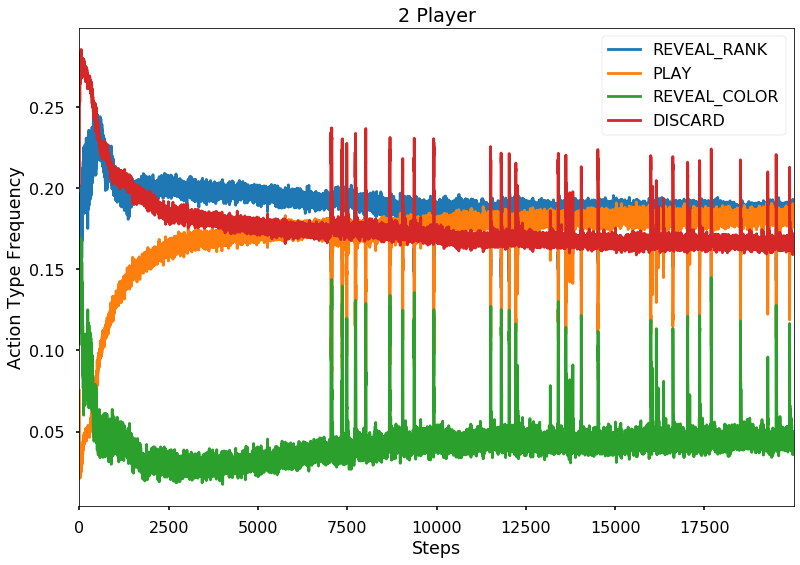

In [290]:
dat.plot()
plt.title('2 Player')
plt.ylabel('Action Type Frequency')
plt.xlabel('Steps')

(0, 0.2)

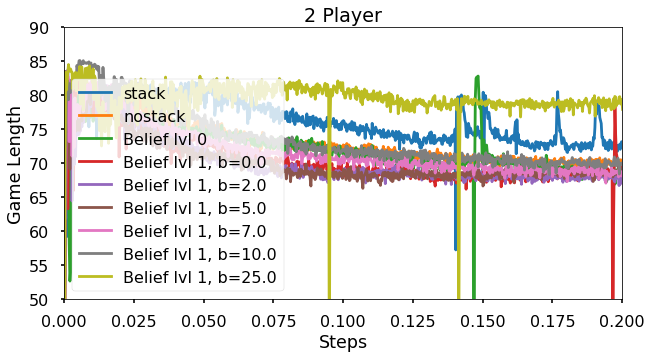

In [29]:
plt.figure(figsize=(10,5))
resample = 5
for v in variants:
    plt.plot(experiment[v]['cumulative_steps'][::resample] / total_steps, 
                 experiment[v]['ep_lens'][::resample],
             label=v)

plt.legend()
plt.title('2 Player')
plt.ylabel('Game Length')
plt.xlabel('Steps')
plt.ylim((50,90))
plt.xlim((0,.2))

# Eval Episode Results

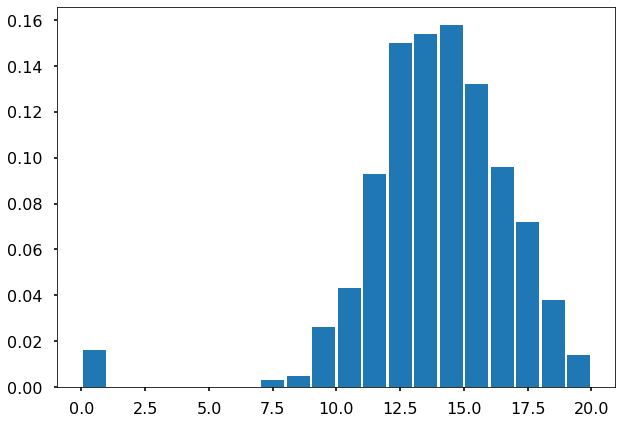

# Bard & Foerster Results

Text(0.5, 1.0, 'Bard, Foerster et al.')

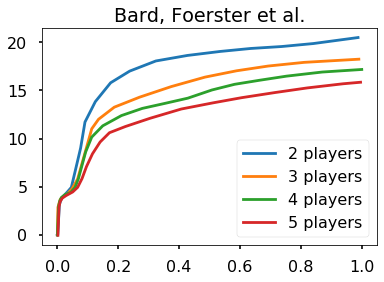

In [109]:
for k, v in webplot_data.items():
    plt.plot(v[:,0], v[:,1], label=k)

plt.legend()
plt.title("Bard, Foerster et al.")